# Usage of modeling

Please read [README.md](../README.md) in advance.

## Modeling

Modeling means here training of several models and evaluate the trained models.

We use the feature matrix which is obtained in [usage-processing.ipynb](./usage-processing.ipynb). If you have not executed it yet, try once or execute the following command on your terminal.

     $ jupyter nbconvert --execute usage-processing.ipynb 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.display import display, HTML
plt.style.use("fivethirtyeight")

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6 ## width, height (inches)

#pd.set_option('display.max_rows', None)

In [3]:
import warnings
warnings.filterwarnings("ignore")

The variable `label_>50K` is the target variable.

In [4]:
df = pd.read_pickle("../data/feature_matrix.pkl")
target = "label_>50K"
df.describe()

,age,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,fnlwgt,education_10th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_Vietnam,native-country_Yugoslavia,label_>50K
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,3.256100e+04,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,0.029483,0.064279,0.000215,0.034274,0.078038,0.039864,0.000430,1.897784e+05,0.028654,...,0.001136,0.003501,0.000369,0.002457,0.001566,0.000553,0.000584,0.002058,0.000491,0.240810
std,13.640433,0.169159,0.245254,0.014661,0.181935,0.268236,0.195642,0.020731,1.055500e+05,0.166834,...,0.033691,0.059068,0.019194,0.049507,0.039546,0.023506,0.024149,0.045316,0.022162,0.427581
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.228500e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.178270e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.783560e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.370510e+05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.484705e+06,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


First of all we split the data set into a training set and a test set.

In [5]:
## Train-Test splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target],
                                                    test_size=0.4, random_state=3)
print("Size of training set:", X_train.shape[0])
print("Size of test set    :", X_test.shape[0])

Size of training set: 19536
Size of test set    : 13025


The distribution of the target variable is as follows.

In [6]:
y_train.value_counts()

0.0    14864
1.0     4672
Name: label_>50K, dtype: int64

In [7]:
100*y_train.mean() ## percentage of the label ">50K".

23.914823914823916

## Cross-Validation and Pipeline

We will chose hyperparameters by cross-validation (CV). CV can be done by using `sklearn.model_selection.GridSearchCV`.

It is often said that a training set should be rescaled before training. This is because the rescaling often optimizes the training so that we obtain a better model. To do so we construct a `Pipeline` instance, which `GridSearchCV` can be applied to. ([Good tutorial](https://iaml.it/blog/optimizing-sklearn-pipelines)) 

### Remark 

A preprocessing algorithm (rescaling, PCA, etc.) is often applied to the training dataset and then CV is applied to the the preprocessed data set. This should be avoided, because the training preprocessing involves some information from the validation data. As a result the training preprocessing can cause "overfitting". `Pipeline` solves this problem.

Because of the same reason we should actually integrate `adhoc.preprocessing.MultiConverter` to `Pipeline`. Namely `MultiConverter` fills missing values by some statistics ("mean", "median" and "most frequent class"). But such statistics are hardly ever overfitted if we have enough data, and it is more important that the column names are fixed. 

Imagine you drop the dummy variable "White" in the first CV and "Other" in the second CV because the majority class can change. Namely your feature matrices can have different features. This is very confusing. Therefore we apply `MultiConverter` before CV.

If you specify all dropping values manually, then you can integrate your `MultiConverter` instance in `Pipeline` without any problem.

In [8]:
try:
    from adhoc.modeling import grid_params, simple_pipeline_cv
except ImportError:
    import sys
    sys.path.append("..")
    from adhoc.modeling import grid_params, simple_pipeline_cv

Let us try to train a model and pick the best hyperparameters. `grid_params` is a dict of simple `grid_param` for several models. You can use it for a simple analysis.

`simple_pipline_cv` creates a simple `Pipeline` instance which consists of a Transformer for preprocessing (such as `MinMaxScaler`) and an ordinary estimator instance and put it in `GridSearchCV`. 

Remark: We use 2-fold cross-validation just only for the CI-pipeline.

In [9]:
from sklearn.linear_model import LogisticRegression

plr = simple_pipeline_cv(name="plr", model=LogisticRegression(penalty="elasticnet", solver="saga"), 
                         param_grid=grid_params["LogisticRegression"], cv=2) ## GridSearchCV instance
plr.fit(X_train, y_train);

The result of the cross-validation is stored in `cv_results_` attribute.

In [10]:
pd.DataFrame(plr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_plr__C,param_plr__l1_ratio,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.314768,0.012744,0.009640,0.000540,0.1,0.1,"{'plr__C': 0.1, 'plr__l1_ratio': 0.1}",0.844083,0.836814,0.840448,0.003634,7,0.839169,0.843673,0.841421,0.002252
1,0.324659,0.011075,0.010005,0.000521,0.1,0.5,"{'plr__C': 0.1, 'plr__l1_ratio': 0.5}",0.844287,0.835790,0.840039,0.004249,8,0.838043,0.843468,0.840756,0.002713
2,0.380944,0.005138,0.014333,0.003222,0.1,0.9,"{'plr__C': 0.1, 'plr__l1_ratio': 0.9}",0.844287,0.835790,0.840039,0.004249,8,0.838145,0.844697,0.841421,0.003276
3,0.479710,0.013643,0.009477,0.000073,1,0.1,"{'plr__C': 1.0, 'plr__l1_ratio': 0.1}",0.849713,0.841216,0.845465,0.004249,6,0.846949,0.851863,0.849406,0.002457
4,0.576577,0.006202,0.009258,0.000165,1,0.5,"{'plr__C': 1.0, 'plr__l1_ratio': 0.5}",0.852682,0.842547,0.847615,0.005068,5,0.847154,0.852580,0.849867,0.002713
5,0.828532,0.043622,0.009428,0.000014,1,0.9,"{'plr__C': 1.0, 'plr__l1_ratio': 0.9}",0.852989,0.845106,0.849048,0.003941,3,0.849099,0.854730,0.851914,0.002815
6,1.212735,0.102890,0.010180,0.001077,10,0.1,"{'plr__C': 10, 'plr__l1_ratio': 0.1}",0.852477,0.845618,0.849048,0.003430,3,0.850328,0.855446,0.852887,0.002559
7,1.419481,0.152834,0.010795,0.001661,10,0.5,"{'plr__C': 10, 'plr__l1_ratio': 0.5}",0.852375,0.845823,0.849099,0.003276,2,0.850123,0.854730,0.852426,0.002303
8,1.611487,0.041229,0.009077,0.000888,10,0.9,"{'plr__C': 10, 'plr__l1_ratio': 0.9}",0.852887,0.845925,0.849406,0.003481,1,0.850020,0.854423,0.852222,0.002201


We can compute the confident interval of the cross-validation scores with `cv_results_summary`.

In [11]:
from adhoc.modeling import cv_results_summary

cv_results_summary(plr)

,mean_test_score,std_test_score,test_CI_low,test_CI_high,mean_train_score,param_plr__C,param_plr__l1_ratio
rank_test_score,,,,,,,
1,0.849406,0.003481,0.818133,0.880680,0.852222,10,0.9
2,0.849099,0.003276,0.819665,0.878533,0.852426,10,0.5
3,0.849048,0.003941,0.813635,0.884460,0.851914,1,0.9
3,0.849048,0.003430,0.818234,0.879861,0.852887,10,0.1
5,0.847615,0.005068,0.802084,0.893145,0.849867,1,0.5
6,0.845465,0.004249,0.807293,0.883637,0.849406,1,0.1
7,0.840448,0.003634,0.807795,0.873101,0.841421,0.1,0.1
8,0.840039,0.004249,0.801867,0.878211,0.840756,0.1,0.5
8,0.840039,0.004249,0.801867,0.878211,0.841421,0.1,0.9


If we have a linear model, then `show_coefficients` shows the regression coefficients.

If you have a Pipeline with a scaler, then the regression coefficients are the coefficients after the scaler. Therefore you can use the absolute values of regression coefficients as "feature importance" (depending on your whole pipeline). But on the other hand you can not interpret the coefficients in the original scales.

In [12]:
from adhoc.modeling import show_coefficients

show_coefficients(plr, X_train.columns).sort_values(by=1.0, ascending=False)

,1.0
capital-gain,24.265731
hours-per-week,3.201697
education_Doctorate,2.607054
education_Prof-school,2.399269
age,1.807377
...,...
native-country_Columbia,-2.610968
workclass_Without-pay,-2.764542
occupation_Priv-house-serv,-4.650571
intercept,-4.779485


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree = GridSearchCV(DecisionTreeClassifier(random_state=3),
                    grid_params["DecisionTree"], cv=2)
tree.fit(X_train,y_train)
cv_results_summary(tree)

,mean_test_score,std_test_score,test_CI_low,test_CI_high,param_max_leaf_nodes
rank_test_score,,,,,
1,0.842394,0.002815,0.817099,0.867688,12
2,0.842240,0.004197,0.804528,0.879952,24
3,0.828419,0.001024,0.819221,0.837617,6
4,0.802058,0.000870,0.794239,0.809876,3


A simple wrapper function for `sklearn.tree.export_graphviz` is available: 

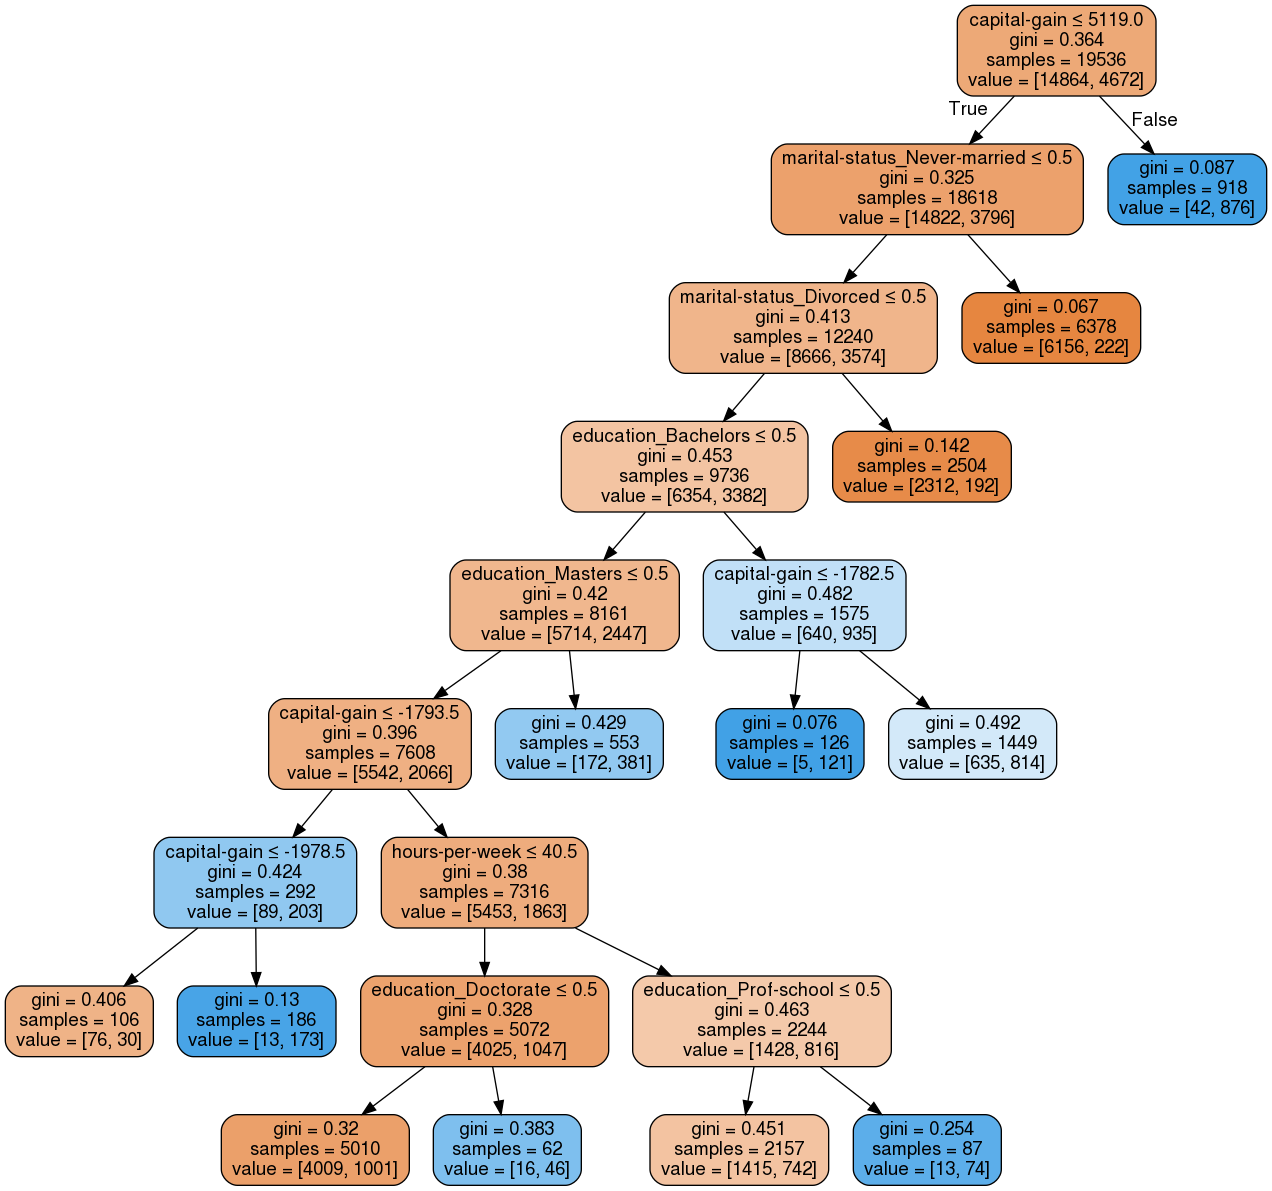

In [14]:
from adhoc.modeling import show_tree

show_tree(tree, X_train.columns)

Here is the feature importance of the decision tree.

In [15]:
from adhoc.modeling import show_feature_importance

s_fi_tree = show_feature_importance(tree, X_train.columns)
s_fi_tree[s_fi_tree > 0]

capital-gain                    0.457180
marital-status_Never-married    0.213550
marital-status_Divorced         0.112372
education_Bachelors             0.087750
education_Masters               0.069160
hours-per-week                  0.029604
education_Prof-school           0.016524
education_Doctorate             0.013859
Name: importance, dtype: float64

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = GridSearchCV(RandomForestClassifier(random_state=3),
                  grid_params["RandomForest"], cv=2)
rf.fit(X_train,y_train)
cv_results_summary(rf)

,mean_test_score,std_test_score,test_CI_low,test_CI_high,param_max_depth,param_n_estimators
rank_test_score,,,,,,
1,0.810555,0.002611,0.787100,0.834010,5,50
2,0.810094,0.000614,0.804575,0.815613,5,10
3,0.808456,0.000717,0.802018,0.814895,5,30
4,0.795455,0.002662,0.771540,0.819369,3,50
5,0.793356,0.003327,0.763462,0.823249,3,30
6,0.766687,0.000205,0.764848,0.768527,3,10


In [17]:
s_fi_rf = show_feature_importance(rf, X_train.columns).sort_values(ascending=False)
s_fi_rf[s_fi_rf>0.01]

capital-gain                    0.265033
marital-status_Never-married    0.120061
age                             0.113517
hours-per-week                  0.059599
sex_Male                        0.051750
occupation_Exec-managerial      0.050867
education_Bachelors             0.044656
relationship_Not-in-family      0.043367
education_Masters               0.040229
relationship_Own-child          0.034017
education_Prof-school           0.033066
relationship_Unmarried          0.028206
marital-status_Divorced         0.027640
education_Doctorate             0.018897
occupation_Other-service        0.013527
relationship_Wife               0.010812
workclass_Self-emp-inc          0.010127
Name: importance, dtype: float64

In [18]:
from xgboost.sklearn import XGBClassifier

xgb_params = {"n_estimators":[10,20], "learning_rate":[0.1,0.01]}
xgb = GridSearchCV(XGBClassifier(max_depth=10, random_state=51),
                   xgb_params, cv=2)
xgb.fit(X_train,y_train)
cv_results_summary(xgb)

,mean_test_score,std_test_score,test_CI_low,test_CI_high,param_learning_rate,param_n_estimators
rank_test_score,,,,,,
1,0.858774,0.003532,0.827040,0.890507,0.1,20
2,0.857647,0.004044,0.821315,0.893980,0.1,10
3,0.851095,0.004249,0.812924,0.889267,0.01,20
4,0.846847,0.005119,0.800857,0.892837,0.01,10


In [19]:
s_fi_xgb = show_feature_importance(xgb, X_train.columns).sort_values(ascending=False)
s_fi_xgb[s_fi_xgb>0.01]

marital-status_Never-married            0.411490
marital-status_Divorced                 0.178879
capital-gain                            0.034367
education_7th-8th                       0.027546
education_11th                          0.026459
occupation_Handlers-cleaners            0.025572
marital-status_Widowed                  0.019615
marital-status_Separated                0.018957
marital-status_Married-spouse-absent    0.018658
occupation_Farming-fishing              0.016383
occupation_Other-service                0.016016
occupation_Exec-managerial              0.015109
education_Masters                       0.014401
education_Bachelors                     0.014347
education_Doctorate                     0.013777
relationship_Unmarried                  0.012971
education_Prof-school                   0.012544
relationship_Not-in-family              0.012391
education_Assoc-voc                     0.011579
education_9th                           0.011553
Name: importance, dt

## Understanding a trained model

Let's look at predictions of a trained decision tree model. According to its feature importance we create 2 continuous variables and 2 discrete variables, using the following variables.

- capital-gain
- marital-status_Never-married
- marital-status_Divorced
- education_Bachelors
- education_Masters
- hours-per-week

Namely we create a categorical variables `marital-status` and `education`. In other words, we apply something like `LebelBinarizer.inverse_transform` with limited values. `adhoc.modeling.recover_label` does the job.

In [20]:
from adhoc.modeling import recover_label

field2columns = {"marital-status": ["marital-status_Never-married", "marital-status_Divorced"],
                 "education": ["education_Bachelors", "education_Masters"]}

df_train = X_train.copy()
recover_label(df_train, field2columns, sep="_", inplace=True)

yhat = tree.predict_proba(X_train)
df_train["prob"] = yhat[:,1]
df_train["pred"] = tree.predict(X_train)
df_train[target] = y_train

`adhoc.modeling.recover_label` create a column `marital-status` out of two columns `marital-status_Never-married` and `marital-status_Divorced`. The rule is as follows:

- `marital-status` is `Never_married` if `marital-status_Never-married == 1`
- `marital-status` is `Divorced` if `marital-status_Divorced == 1` 
- Otherwise `marital-status` is `other`.

We do the similar preprocessing to create `education`. The following table show the concrete transformation.

In [21]:
cols = []
for field, columns in field2columns.items():
    cols.append(field)
    cols.extend(columns)

df_train[cols].drop_duplicates()

,marital-status,marital-status_Never-married,marital-status_Divorced,education,education_Bachelors,education_Masters
2426,other,0.0,0.0,other,0.0,0.0
13892,other,0.0,0.0,Bachelors,1.0,0.0
3767,Never-married,1.0,0.0,other,0.0,0.0
11577,Divorced,0.0,1.0,Bachelors,1.0,0.0
5635,Divorced,0.0,1.0,other,0.0,0.0
19866,other,0.0,0.0,Masters,0.0,1.0
13995,Never-married,1.0,0.0,Bachelors,1.0,0.0
1907,Never-married,1.0,0.0,Masters,0.0,1.0
3979,Divorced,0.0,1.0,Masters,0.0,1.0


The following scatter plot shows the predictions of the decision tree on the training set. The color shows the predicted probabilities: The red points are predicted as positive and the blue points are predicted as negative.

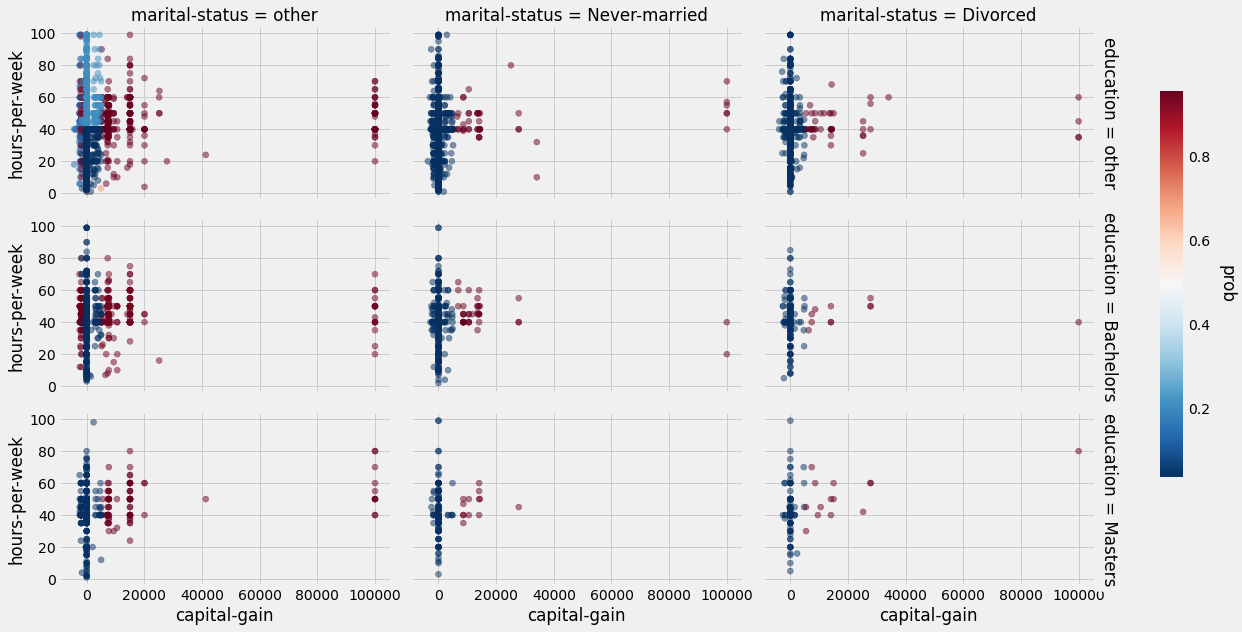

In [22]:
from adhoc.utilities import facet_grid_scatter_plot

facet_grid_scatter_plot(data=df_train, col="marital-status", row="education", 
                        x="capital-gain", y="hours-per-week", c="prob", 
                        cmap="RdBu_r", margin_titles=True)

While the scatter plot gives a good overview of predictions, it is quite difficult to evaluate quantitatively just by looking at the diagrams. Therefore we bins x and y variables and show the average of probabilities for each pair of bins as a heat map.

Each of the following heat maps corresponds to a pair of values of `marital-status` and `education`. Note that the bins are different according to heat maps. The choice of bins are optimized by decision trees. The bins without any color/any number has no instances.

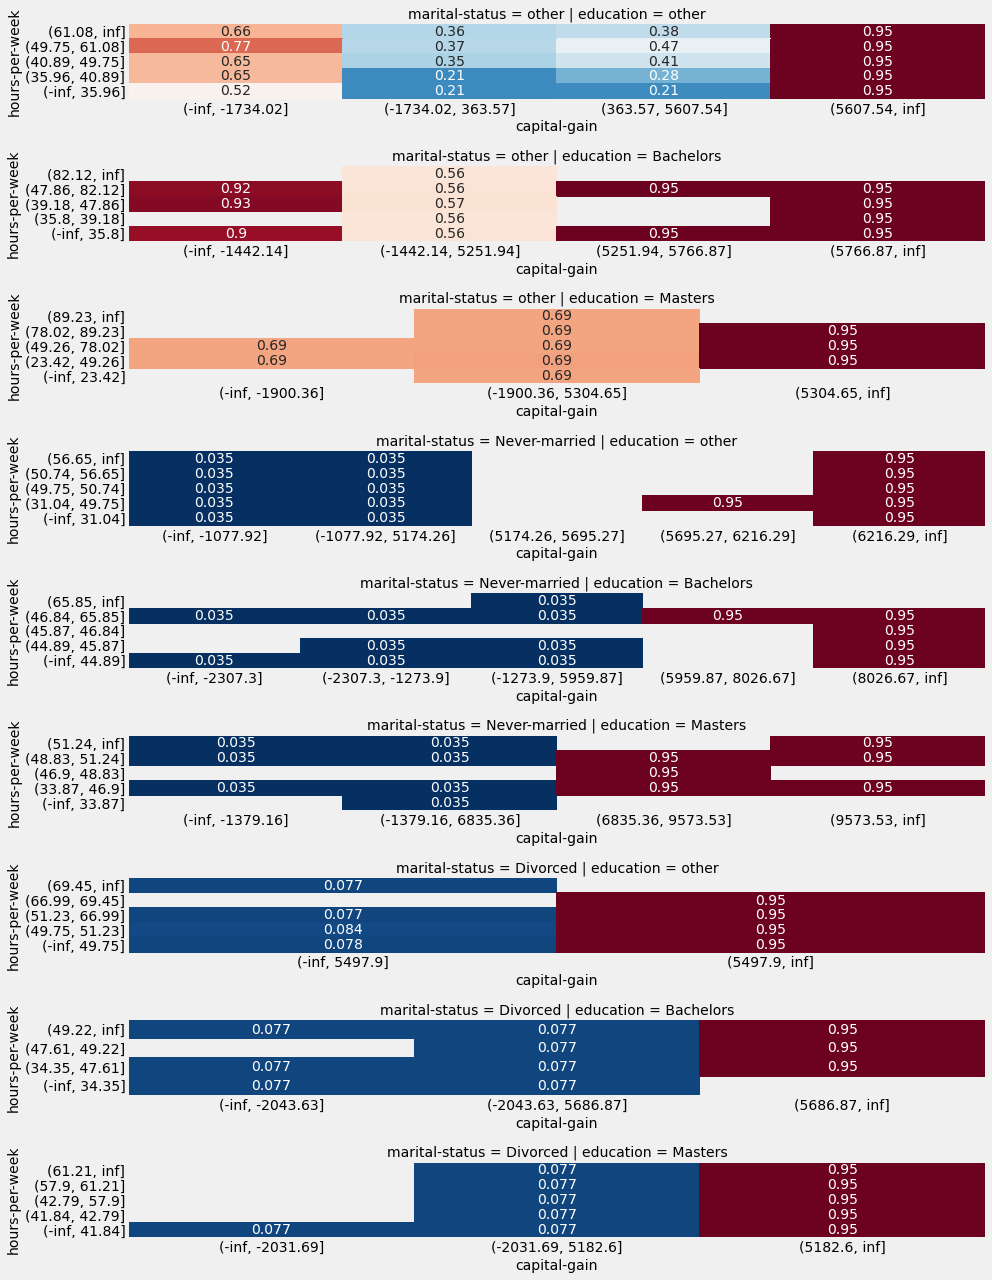

In [23]:
from adhoc.utilities import bins_heatmap

bins_heatmap(df_train, cat1="marital-status", cat2="education", x="capital-gain", y="hours-per-week",
             target="prob", center=0.5, cmap="RdBu_r", fontsize=14)

Just in case. The above heat maps show the average probabilities which are predicted by a trained decision tree model on the training set, not the true values of the target variable.

## Evaluation of the model by AUC

In some cases (especially when the target variable is a skewed binary variable) you need to evaluate of a trained model by a special metric such as AUC.

**Remark**: If you want to do the following analysis, I strongly recommend to split your original dataset into 3 datasets: training set, validation set and test set. You train a model, choosing "roc_auc" as a scoring function and do the following analysis with the validation set.

(Why we did not do so? Well, it might be confusing at glance. *Why don't we use the validation set for choosing hyperparameters?*)

### Lead prioritization

Let us assume that our data set is a list of customers and the target customers of your product (or service) is people who earn relatively much. And therefore you have decided to contact customers directly (for example by telephone) instead of on-line advertising to huge number of audience. Because it is time-consuming to contact a customer directory, you want to reduce the number of contacts. 

- A contacting a customer costs €40 on average.
- If the customer buys your product, you get €1000. (This is the price.)

(These numbers have no reality. Just an assumption.)

Since we do not have a data set for successful customers, so we naïvely assume that 10% of the customers with label "`>50K`" buy your product. Because 24% of the customers have label "`>50K`", the proportion of the customer buying the product would be 2.4%. (Of course, your "test set" has no information about the label, neither.)

If you randomly choose a customer and contact her/him. Then your success rate is exactly 2.4%. That is, you get a customer buying your product if you contact 42 customers on average. And therefore getting such a customer costs €1680 on average. This is a deficit. On the other hand if you can perfectly find a positive customer. Then your success rate will be 10%. That is, you will get a customer buying your product by contacting 10 customers on average and it costs €400.

One of the difficulties of this challenge is that the accuracy of the model is not a right metric. Let us look at the performance of the random forest classifier (on the training set).

In [24]:
from adhoc.modeling import ROCCurve

def performance_check(model, X:pd.DataFrame, y:pd.Series, threshold:float=0.5) -> pd.DataFrame:
    roc_curve = ROCCurve(y,model.predict_proba(X)[:,1])
    score = roc_curve.get_scores_thru_threshold(threshold=threshold)
    ct = roc_curve.get_confusion_matrix(threshold=threshold)
    
    n_contact = ct.loc[1,:].sum()
    success_rate = 0.1*score["precision"]
    contact_cost = 40
    price = 1000
    profit = price*success_rate*n_contact - contact_cost*n_contact
    
    print("- Your model has %d%% accuracy." % (100*score["accuracy"]))
    print("- You will contact %d customers." % n_contact)
    print("- You can reach %d%% of positive customers" % (100*score["recall"]))
    print("- Your success rate is %0.1f%%" % (100*success_rate))
    print("- Your profit would be %d" % profit)
    return ct

performance_check(rf, X_train, y_train)

- Your model has 80% accuracy.
- You will contact 984 customers.
- You can reach 20% of positive customers
- Your success rate is 9.8%
- Your profit would be 57140


true value,0,1
prediction,,
0,14845,3707
1,19,965


Let's look at another model: XGBoosting.

In [25]:
performance_check(xgb, X_train, y_train)

- Your model has 87% accuracy.
- You will contact 3293 customers.
- You can reach 59% of positive customers
- Your success rate is 8.4%
- Your profit would be 144980


true value,0,1
prediction,,
0,14338,1905
1,526,2767


So what is the right metric?

1. Profit. Then you definitely want to choose the XGBoosting model. 
2. Success rate (or precision). If you want to find a small number of customers buying your product quickly, because it is challenging and therefore you want to receive feedback quickly to improve your product and to release a new version. Of course the assumption that 10% of positive customers buy the product can be too optimistic, so you want to change strategy in an early stage.

If you choose the second option, then you want to choose the random forest classifier because of the high success rate. But you can obtain a better model by tweaking threshold of the XGBoosting model:

In [26]:
performance_check(xgb, X_train, y_train, threshold=0.8)

- Your model has 82% accuracy.
- You will contact 1166 customers.
- You can reach 24% of positive customers
- Your success rate is 10.0%
- Your profit would be 69760


true value,0,1
prediction,,
0,14862,3508
1,2,1164


The classifiers which we trained predict actually probabilities that a customer is positive and therefore we naturally use 0.5 as a threshold/boundary of predictions: If the probability is larger than 0.5, then the customer would be positive. So why don't we start with the customer with high probabilities? In the third crosstab we use 0.8 as the threshold, then you will achieve a model with a better precision. Here we should note that the accuracy becomes worse than the model with threshold 0.5.

In general, the more accurate the classifier is, the better the predictions are. But this is not always the case, especially when you have a specific metric.

There is a problem. The precision is often not a good metric to optimize. You can also achieve that a random forest classifier with a good precision just by choosing a high threshold:

In [27]:
performance_check(rf, X_train, y_train, threshold=0.7)

- Your model has 77% accuracy.
- You will contact 338 customers.
- You can reach 7% of positive customers
- Your success rate is 10.0%
- Your profit would be 20280


true value,0,1
prediction,,
0,14864,4334
1,0,338


But as you see, you can reach only 338 positive customers. Is it enough to close 33 contracts? If the assumption is too optimistic, you can find less than 33 customers buying your product. That is, it is also important to reach larger number of positive customers. Therefore you have actually two measures to optimize.

- Precision: the proportion of positive customers among the customer you will contact.
- Recall: the proportion of positive customers you can reach.

There are two problems:

1. The metrics are determined after choosing a threshold. Then how should we train a model and tune hyperparameters?
2. It is problematic that there are two metrics to optimize. Which has priority and how do we measure it.

The standard solutions to the above questions are following:

1. Train a model in a usual way, but tune hyperparameters by looking at area under the ROC curve.
2. Use F1-metric and choose the threshold which maximizes it. Or optimize your metric by varying threshold.

(You might want to perform a special sampling method if you need.)

### ROC curve and AUC

Assume that you have a trained model predicting probabilities (or scores). Then choosing a threshold, you have a crosstab as above, and therefore you also have False-Positive rate (FP rate) and True-Positive rate (TP rate) of the predictions. The ROC (Receiver Operating Characteristic) curve is the curve of pairs (FP rate, TP rate) by varying the threshold.

The following line curve is the ROC curve of the XGBoosting model.

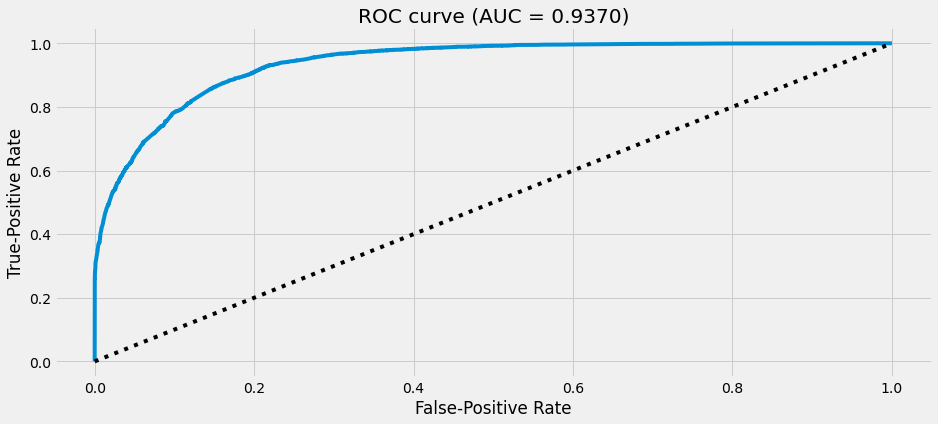

In [28]:
y_score_xgb = xgb.predict_proba(X_train)[:,1]
roc_curve_xgb = ROCCurve(y_true=y_train, y_score=y_score_xgb)
roc_curve_xgb.show_roc_curve()

Usually this curve moves from (1,1) (Every customer is positive) to (0,0) (Every customer is negative) and "usually" the curve lies over the diagonal line (dotted line in the diagram). (If not, you have a wrong classifier.) The ROC curve shows the performance of your model with all possible threshold.

Since the upper left point (FP=0, TP=1) corresponds the perfect classifier, the ROC curve approaches upper left corner if your model can predict correctly. We can measure "how the ROC curve approaches to upper left" as the area under the ROC curve (AUC).

The following curve is the ROC curve of the random forest classifier. AUC is slightly worse than one of XGBoosting.

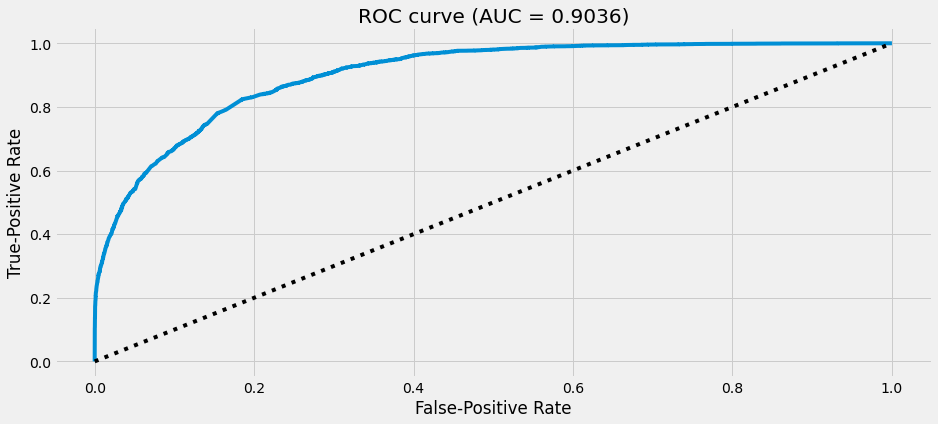

In [29]:
y_score_rf = rf.predict_proba(X_train)[:,1]
roc_curve_rf = ROCCurve(y_true=y_train, y_score=y_score_rf)
roc_curve_rf.show_roc_curve()

Let's look at the F1 scores. We recall that the F1-score is defined by the harmonic mean of $P$ and $R$:

$$F = \dfrac{2PR}{P+R}$$

Here $P$ is the precision and $R$ is the recall. The following heat map shows the F1-scores for various precisions and recalls.

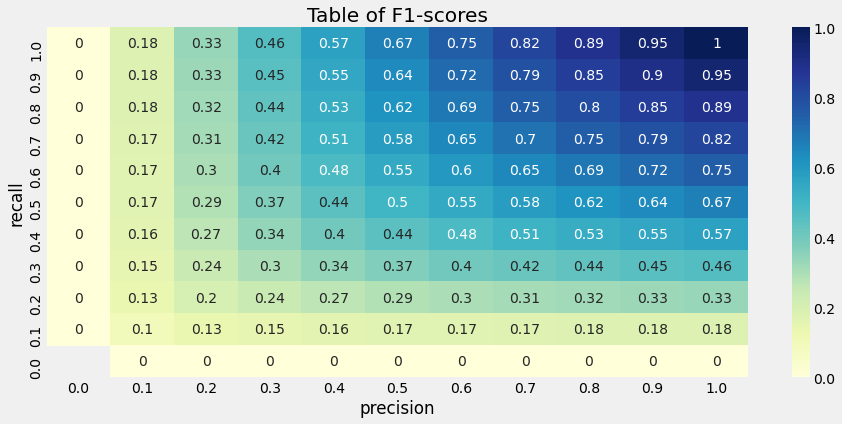

In [30]:
from itertools import product

vals = np.round(0.1*np.arange(11),1)
df_f1 = pd.DataFrame(list(product(vals,vals)), columns=["precision","recall"])
df_f1["F1-score"] = 2*df_f1["precision"]*df_f1["recall"]/(df_f1["precision"]+df_f1["recall"])
df_f1 = df_f1.pivot(index="recall", columns="precision", values="F1-score").sort_index(ascending=False)
sns.heatmap(df_f1, cmap="YlGnBu", annot=True)
plt.title("Table of F1-scores");

Let us look at line curves of the metrics (recall, precision and F1-score) by thresholds.

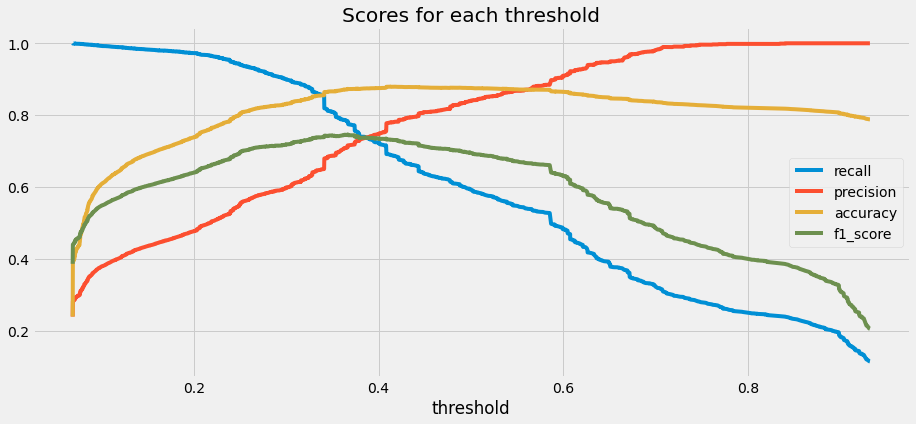

In [31]:
roc_curve_xgb.show_metrics() ## takes relatively long

The precise values of metrics can be obtain by `scores` property:

In [32]:
roc_curve_xgb.scores.head()

,recall,precision,fp_rate,accuracy,f1_score,n_pos_pred
threshold,,,,,,
0.932182,0.114298,1.0,0.0,0.788186,0.205148,534.0
0.931410,0.114726,1.0,0.0,0.788288,0.205837,536.0
0.929167,0.119649,1.0,0.0,0.789466,0.213726,559.0
0.928363,0.119863,1.0,0.0,0.789517,0.214067,560.0
0.925515,0.132491,1.0,0.0,0.792537,0.233982,619.0


By using this it is easy to find the threshold which maximizes F1-score.

In [33]:
roc_curve_xgb.scores.sort_values(by="f1_score", ascending=False).head()

,recall,precision,fp_rate,accuracy,f1_score,n_pos_pred
threshold,,,,,,
0.366579,0.779324,0.715746,0.097282,0.873208,0.746183,5087.0
0.366491,0.779324,0.715605,0.097349,0.873157,0.746107,5088.0
0.366727,0.779110,0.715690,0.097282,0.873157,0.746055,5086.0
0.364254,0.785317,0.709260,0.101184,0.871673,0.745353,5173.0
0.364019,0.786173,0.708526,0.101655,0.871519,0.745333,5184.0


In [34]:
best_threshold = roc_curve_xgb.scores.sort_values(by="f1_score", ascending=False).index[0]
roc_curve_xgb.get_confusion_matrix(threshold=best_threshold)

true value,0,1
prediction,,
0,13418,1031
1,1446,3641


The above crosstab is the result of the threshold with the best F1-score. Of course you can choose another threshold, for example 0.7, so that you obtain a better precision.

In [35]:
roc_curve_xgb.get_confusion_matrix(threshold=0.7)

true value,0,1
prediction,,
0,14835,3165
1,29,1507


Or you might want to choose the threshold which maximizes the profit.

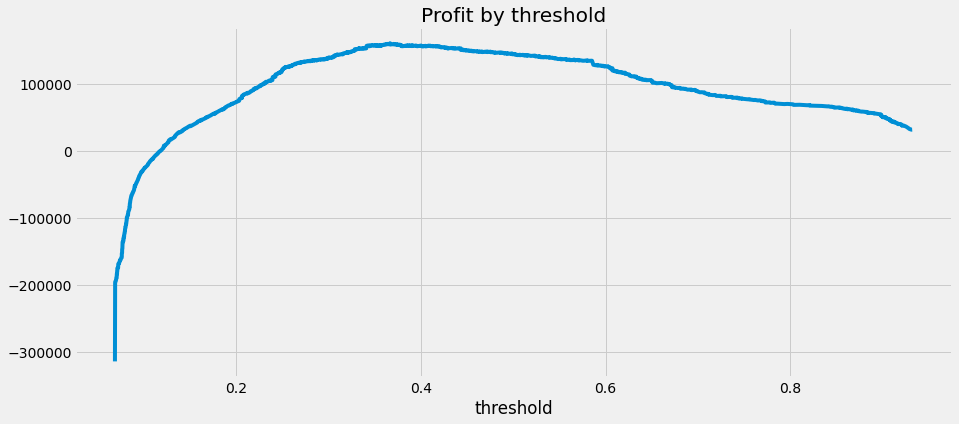

In [36]:
df_performance = roc_curve_xgb.scores.copy()
price = 1000
cost = 40

df_performance["success_rate"] = 0.1*df_performance["precision"]
df_performance["n_contract"] = (df_performance["success_rate"]*df_performance["n_pos_pred"]).astype(int)
df_performance["profit"] = price*df_performance["n_contract"] - cost*df_performance["n_pos_pred"]
df_performance["profit"].plot()
plt.title("Profit by threshold");

The best threshold is 0.366727 and the profit (on training set) will be €160 560.

In [37]:
df_performance.sort_values(by="profit", ascending=False).head(1)

,recall,precision,fp_rate,accuracy,f1_score,n_pos_pred,success_rate,n_contract,profit
threshold,,,,,,,,,
0.366727,0.77911,0.71569,0.097282,0.873157,0.746055,5086.0,0.071569,364,160560.0


Another usage of the trained model is to use probabilities as scores. The higher the score is, the more likely the customer is positive. Therefore we can contact positive customers by contacting customers in the descending order of scores.

First of all the expected value of a number of positive customer agrees with the proportion of positive customers if we contact randomly. Now we have a probability of positivity for each customer. Then the expected value of the number of positive customers is just the sum of the probabilities.

Here is a problem. What is the expected value of the whole (training) dataset?

In [38]:
print("Expected value (random contact)         : %s" % y_train.sum())
print("Expected value (predicted probabilities): %s" % y_score_xgb.sum())

Expected value (random contact)         : 4672.0
Expected value (predicted probabilities): 5348.788


In other words, the model says that you can reas more 5000 positive customers. This can not happen. But this is normal because we do not train a model so that the expected values agree. One of the easiest solution to the problem is scaling. That is, we multiply a certain constant so that the expected value of the number of positive customers with the predicted probability agrees with the expected value with equally likely probabilities.

Then the expected values of number of positive customers by the number of contacts look like following.

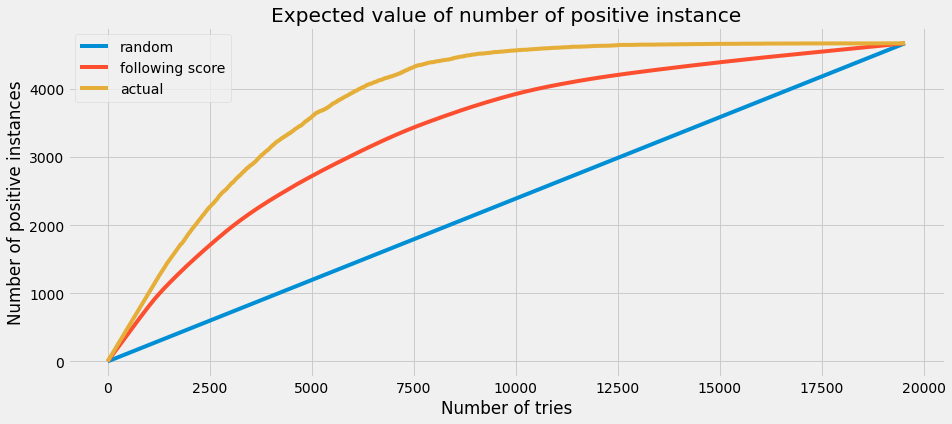

In [39]:
proportion_positive = y_train.mean()
roc_curve_xgb.show_expected_value(proportion_positive=proportion_positive, scaling=True)

According to the graph you could reach 2721 positive customers if you contact 5000 customers in the descending order of scores. (But you will actually reach 3591 positive customers.) If you contact randomly, then you can reach only 1195 positive customer.

In [40]:
roc_curve_xgb.optimize_expected_value(proportion_positive=proportion_positive, scaling=True).loc[5000,:]

index                15636.000000
y_true                   1.000000
score                    0.374032
scaled_score             0.326705
expected (score)      2721.382568
expected (random)     1195.741196
n_true                3591.000000
Name: 5000, dtype: float64

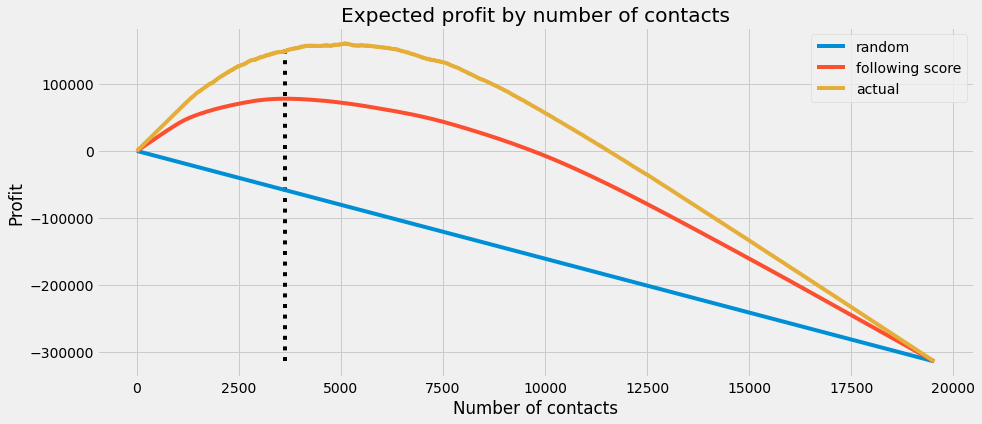

In [41]:
def profit_df(roc:ROCCurve, price:int, cost:int) -> pd.DataFrame:
    df_profit = roc.optimize_expected_value(proportion_positive=proportion_positive, 
                                                  scaling=True).copy()
    df_profit["following score"] = price*0.1*df_profit["expected (score)"] - cost*df_profit.index
    df_profit["random"] = price*0.1*df_profit["expected (random)"] - cost*df_profit.index
    df_profit["actual"] = price*0.1*df_profit["n_true"] - cost*df_profit.index
    return df_profit


df_profit = profit_df(roc_curve_xgb, price, cost)
best_n_try = df_profit.sort_values(by="following score", ascending=False).index[0]

def show_profit(df_profit:pd.DataFrame, xintercept:int):
    cols = ["random", "following score", "actual"]
    df_profit[cols].plot()
    plt.vlines(xintercept, ymin=df_profit["actual"].min(), ymax=df_profit["actual"].max(),
               linestyle=":")
    plt.title("Expected profit by number of contacts")
    plt.xlabel("Number of contacts")
    plt.ylabel("Profit");
    
show_profit(df_profit, best_n_try)

According to the graph the profit is maximized if we contacts 3637 customers in the descending order of scores. The expected profit will be €78025. This number is very small than the profit we compute above. This is because of the scaling. 

In [42]:
df_profit.loc[best_n_try,:]

index                 22613.000000
y_true                    1.000000
score                     0.457980
scaled_score              0.400031
expected (score)       2235.051270
expected (random)       869.782146
n_true                 2946.000000
following score       78025.125000
random               -58501.785422
actual               149120.000000
Name: 3637, dtype: float64

We have seen two approaches:

1. Contact all customers which are predicted as positive customers.
2. Use predicted probabilities as scores and contact customers in the descending order of scores.

**You should not show the both approaches to the audience.** They are definitely confused by the multiple solutions and you are going to be asked which solution is correct/reliable.

You should make it clear how the predicted model is going to be used? What is the goal of the analysis? If it is clear, then you should choose only one metric to optimize.

### Evaluation of the model on test set

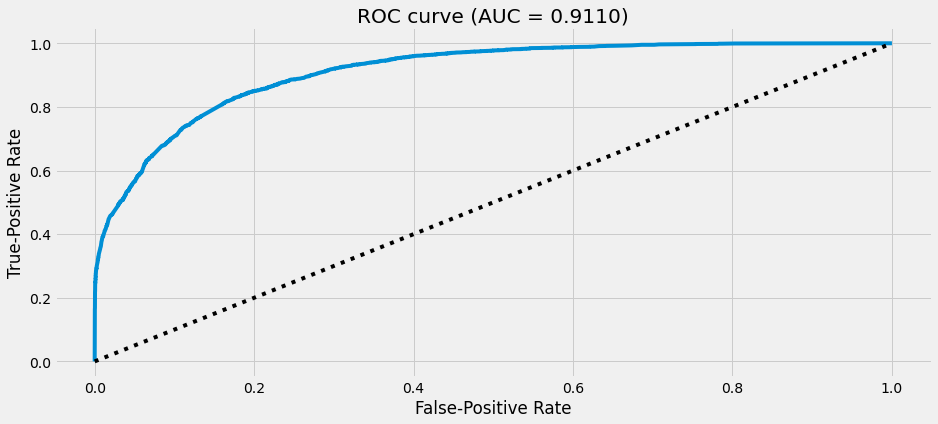

In [43]:
y_score = xgb.predict_proba(X_test)[:,1]
roc = ROCCurve(y_true=y_test, y_score=y_score)
roc.show_roc_curve()

When computing expected value, we have to use the proportion of the positive customers in the **training set** (not the test set). This is because we do not know the actual proportion of positive customers in the test set and we also have to predict it.

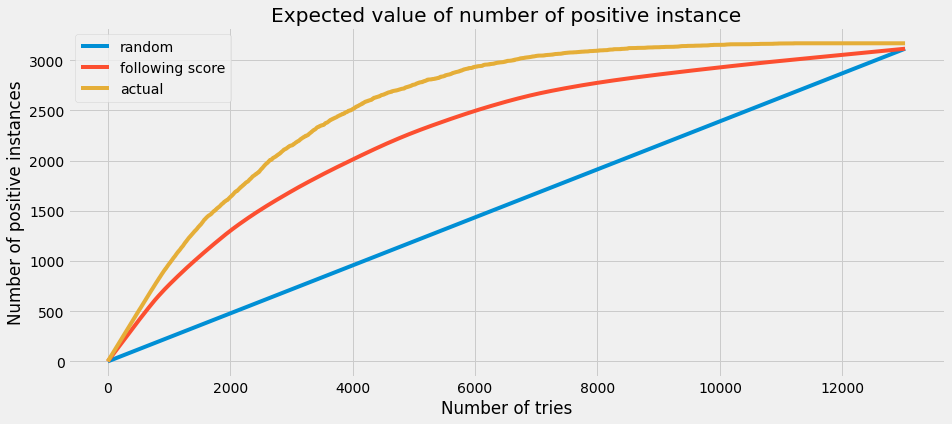

In [44]:
roc.show_expected_value(proportion_positive=proportion_positive, scaling=True)

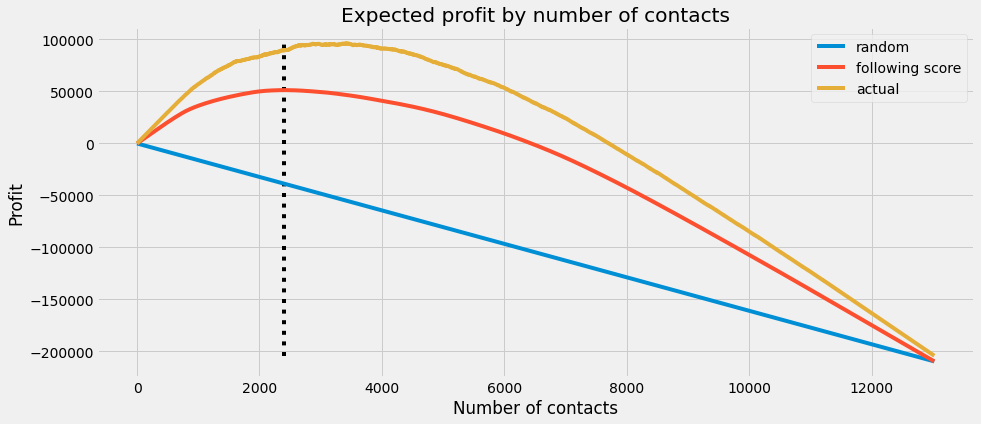

In [45]:
df_profit = profit_df(roc, price, cost)
best_n_try_test = df_profit.sort_values(by="following score", ascending=False).index[0]
show_profit(df_profit, best_n_try_test)

In [46]:
df_profit.loc[best_n_try_test,:]

index                15792.000000
y_true                   0.000000
score                    0.460232
scaled_score             0.400134
expected (score)      1475.602173
expected (random)      575.629812
n_true                1858.000000
following score      51280.218750
random              -38717.018837
actual               89520.000000
Name: 2407, dtype: float64

## Environment

In [47]:
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas,matplotlib,seaborn

Sun Jul 05 2020 

CPython 3.7.0
IPython 7.16.1

numpy 1.18.0
scipy 1.5.0
sklearn 0.23.1
pandas 1.0.5
matplotlib 3.2.2
seaborn 0.10.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.12.14-lp151.28.52-default
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
